In [794]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
import time
import pandas as pd

In [795]:
def one_hot_encoding(index):
    encoding = np.zeros(4)
    encoding[index] = 1
    
    return encoding

def generate_diagram():
    D = 20
    diagram = np.zeros((D, D, 4), dtype=np.int8) # 20 x 20 diagram

    color_order = random.sample(range(1, 4 + 1), 4) # pre-picking order of colors for the 4 wires 
    row_order = random.sample(range(20), 2) # pre-picking the order of rows to set to that color
    col_order = random.sample(range(20), 2) # pre-picking the order of columns

    if random.random() <= 0.5: # 50% chance starting with rows/columns 
        diagram[row_order[0],:] = one_hot_encoding(color_order[0] - 1)
        diagram[:,col_order[0]] = one_hot_encoding(color_order[1] - 1)
        diagram[row_order[1],:] = one_hot_encoding(color_order[2] - 1)
        diagram[:,col_order[1]] = one_hot_encoding(color_order[3] - 1)
    else:
        diagram[:,col_order[0]] = one_hot_encoding(color_order[1] - 1)
        diagram[row_order[0],:] = one_hot_encoding(color_order[0] - 1)
        diagram[:,col_order[1]] = one_hot_encoding(color_order[3] - 1)
        diagram[row_order[1],:] = one_hot_encoding(color_order[2] - 1)

    # display(diagram)

    # dangerous = color_order.index(1) < color_order.index(3) # red before yellow means dangerous
    dangerous = (color_order.index(1) < color_order.index(3)) and ((color_order.index(1) % 2) != (color_order.index(3) % 2))
    cut = color_order[2] # 3rd wire "always to be cut"

    return diagram, int(dangerous)

def to_emoji(color):
    colors = { 'red', 'blue', 'yellow', 'green' }
    color_emojis = [ '⬛', '🟥', '🟦', '🟨', '🟩' ]

    return color_emojis[color]

def display(diagram):
    for y in range(len(diagram)):
        for x in range(len(diagram[0])):
            print(to_emoji(diagram[y, x]), end='')
        print("")

In [796]:
def generate_dataset(size):
    diagrams = []
    dangerous = []
    
    for i in range(size):
        diagram, danger = generate_diagram()
        diagrams.append(diagram)
        dangerous.append(danger)
        
    return np.array(diagrams), np.array(dangerous)

diagrams, danger = generate_dataset(5500)

In [797]:
diagrams.shape

(5500, 20, 20, 4)

In [798]:
X_train, X_test, y_train, y_test = train_test_split(diagrams, danger, test_size=500/5500)
num_features = 20 * 20 * 4

X_train = X_train.reshape(-1, num_features)
X_test = X_test.reshape(-1, num_features)

# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5000, 1600), (5000,), (500, 1600), (500,))

In [799]:
pd.DataFrame(y_train).value_counts()

0    3297
1    1703
dtype: int64

In [838]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def f(X, weights):
    return sigmoid(np.dot(X, weights))

def BCE_loss_fn(X, y, weights, r_lambda=0):
    epsilon = 1e-15  # to avoid log(0) error
    predictions = f(X, weights)
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    
    l2_reg_term = r_lambda * np.mean(np.square(weights))
    
    return -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions)) + l2_reg_term

def compute_gradient(X, y, weights, r_lambda=0):
    predictions = f(X, weights)
    error = predictions - y
    
    gradient = np.dot(X.T, error) / X.shape[0]
    
    l2_reg_term = r_lambda * weights

    return gradient + l2_reg_term / X.shape[0]

def compute_gradient_SGD(X, y, weights, index, r_lambda=0):
    predictions = f(X[index], weights)
    error = predictions - y[index]
    gradient = np.dot(X[index].T, error)
    
    l2_reg = r_lambda * weights
    
    return gradient + l2_reg / X.shape[0]

In [839]:
X_train.shape

(5000, 1600)

In [840]:
import numpy as np

# x: data_amount x features
# y: data_amount x 1
# alpha: learning rate
def train(X, y, iterations=100, learning_rate=0.01, r_lambda=0.001):
    # inital weights, 0s
    # weights = np.random.rand(num_features)
    weights = np.zeros((num_features))
    # weights = np.random.uniform(-0.025, 0.025, num_features)
    loss_history = []
    test_loss_history = []

    for i in range(iterations):
        # predictions from model
        
        # compute loss
        loss = BCE_loss_fn(X, y, weights, r_lambda)
        
        # compute gradients
        gradient = compute_gradient(X, y, weights, r_lambda)
        # gradient = compute_gradient_SGD(X, y, weights, random.randint(0, len(y) - 1), 0.1)
        
        # update weights
        weights -= learning_rate * gradient
        # testing on test dataset
        test_predictions = f(X_test, weights)
        test_loss = BCE_loss_fn(X_test, y_test, weights, r_lambda)
        test_acc = accuracy(test_predictions, y_test)
                
        # print iteration
        print(f'Epoch {i}, Loss: {loss}, Test Loss: {test_loss}, Test Accuracy: {test_acc*100:.2f}%')
        
        if i % 10 == 0:
            loss_history.append(loss)
            test_loss_history.append(test_loss)
    
    
    print(f'Final Loss: {loss}, Test Loss: {test_loss}, Test Accuracy: {test_acc*100:.2f}%')
    return weights, loss_history, test_loss_history

trained_weights, loss_history, test_loss_history = train(X_train, y_train, 1000, 1, 0.01)

Epoch 0, Loss: 0.6931471805599454, Test Loss: 0.6548507859362701, Test Accuracy: 63.80%
Epoch 1, Loss: 0.6390462740458499, Test Loss: 0.6562540939047968, Test Accuracy: 63.80%
Epoch 2, Loss: 0.6355973560080813, Test Loss: 0.6573940608776385, Test Accuracy: 63.80%
Epoch 3, Loss: 0.633373448548577, Test Loss: 0.6584430342794587, Test Accuracy: 63.80%
Epoch 4, Loss: 0.631576749403781, Test Loss: 0.6594912363659639, Test Accuracy: 63.80%
Epoch 5, Loss: 0.6301011140582612, Test Loss: 0.6605342577050561, Test Accuracy: 63.80%
Epoch 6, Loss: 0.6288785928379951, Test Loss: 0.6615550065091437, Test Accuracy: 63.80%
Epoch 7, Loss: 0.6278565756913284, Test Loss: 0.6625394771555108, Test Accuracy: 63.80%
Epoch 8, Loss: 0.6269939386696086, Test Loss: 0.6634782733976322, Test Accuracy: 63.60%
Epoch 9, Loss: 0.6262584546418881, Test Loss: 0.6643657747287485, Test Accuracy: 63.40%
Epoch 10, Loss: 0.6256247953452214, Test Loss: 0.6651991484271227, Test Accuracy: 63.40%
Epoch 11, Loss: 0.625072989272196

In [833]:
def accuracy(predictions, labels, threshold=0.5):
    correct_predictions = 0
    for i in range(len(predictions)):
        pred = 1 if predictions[i] >= 0.5 else 0
        if round(predictions[i]) == labels[i]:
            correct_predictions += 1
    accuracy = correct_predictions / len(labels)
    return accuracy

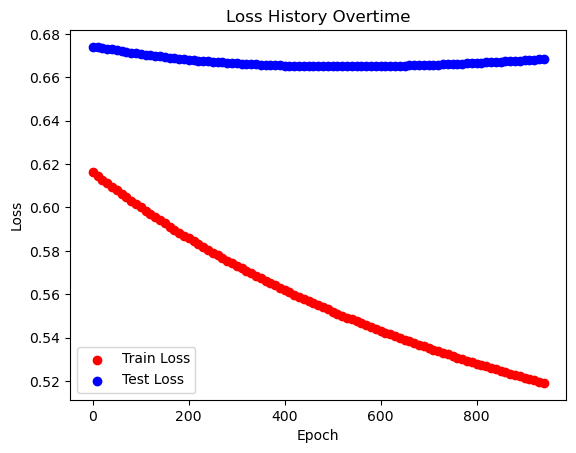

In [841]:
plt.scatter(np.arange(0, len(loss_history[5:])) * 10, loss_history[5:], c='red', label='Train Loss')
plt.scatter(np.arange(0, len(test_loss_history[5:])) * 10, test_loss_history[5:], c='blue', label='Test Loss')
plt.legend()
plt.xlabel('Epoch')  # Replace with your x-axis label
plt.ylabel('Loss')  # Replace with your y-axis label
plt.title('Loss History Overtime')  # Replace with your graph title
plt.show()

In [688]:
def get_batches(X, y, batch_size=10):
    indexes = np.arange(0, len(X))

    random.shuffle(indexes)

    batch_Xs = []
    batch_ys = []
    
    # print("# of batches: ", len(X) / batch_size)
    for i in range(int(len(X) / batch_size)):
        batch_indexes = indexes[i*batch_size:(i+1)*batch_size]

        batch_X = X[batch_indexes]
        batch_Xs.append(batch_X)
        
        batch_y = y[batch_indexes]
        batch_ys.append(batch_y)
        
    return batch_Xs, batch_ys
        
# batch_X, batch_y = get_batches(X_train, y_train, 20)

In [711]:
# batches
# x: data_amount x features
# y: data_amount x 1
# alpha: learning rate
def train(X, y, learning_rate=0.01, iterations=100, batch_size=20):
    # inital weights, 0s
    # weights = np.random.rand(num_features)
    # weights = np.random.uniform(-0.025, 0.025, num_features)
    weights = np.zeros(num_features)
    loss_history = []
    test_loss_history = []

    for i in range(iterations):
        
        batch_Xs, batch_ys = get_batches(X, y, batch_size)
        
        for batch_X, batch_y in zip(batch_Xs, batch_ys):
            # predictions from model
            predictions = f(batch_X, weights)
            
            # compute loss
            loss = BCE_loss_fn(predictions, batch_y)

            # compute gradients
            gradient = compute_gradient(batch_X, batch_y, weights, 0.1)
            # gradient = compute_gradient_SGD(batch_X, batch_y, weights, random.randint(0, len(batch_y) - 1), 0.1)

            # update weights
            weights -= learning_rate * gradient
        
        # testing on test dataset    
        test_predictions = f(X_test, weights)
        test_loss = BCE_loss_fn(test_predictions, y_test)
        test_acc = accuracy(test_predictions, y_test)
        train_acc = accuracy(predictions, y_train)

        # print iteration
        print(f'Epoch {i}, Loss: {loss}, Test Loss: {test_loss}, Train Accuracy: {train_acc*100:.2f}%, Test Accuracy: {test_acc*100:.2f}%')
        
        if i % 10 == 0:
            loss_history.append(loss)
            test_loss_history.append(test_loss)
    
    
    print(f'Final Loss: {loss}, Test Loss: {test_loss}, Test Accuracy: {test_acc*100:.2f}%')
    return weights, loss_history, test_loss_history

trained_weights, loss_history, test_loss_history = train(X_train, y_train, 1, 1000, 1800)

Epoch 0, Loss: 0.6931471805599452, Test Loss: 0.6664195893871218, Train Accuracy: 63.39%, Test Accuracy: 61.50%
Epoch 1, Loss: 0.6486483459219123, Test Loss: 0.6672711596401271, Train Accuracy: 63.39%, Test Accuracy: 61.50%
Epoch 2, Loss: 0.6414218007485603, Test Loss: 0.6683667618571443, Train Accuracy: 63.39%, Test Accuracy: 61.50%
Epoch 3, Loss: 0.6359525230967479, Test Loss: 0.6697421888169945, Train Accuracy: 63.33%, Test Accuracy: 61.00%
Epoch 4, Loss: 0.631537831735545, Test Loss: 0.6713266485872518, Train Accuracy: 63.17%, Test Accuracy: 61.00%
Epoch 5, Loss: 0.6279257720828062, Test Loss: 0.673031095634268, Train Accuracy: 62.78%, Test Accuracy: 61.50%
Epoch 6, Loss: 0.6249328983351643, Test Loss: 0.6747875719174701, Train Accuracy: 62.28%, Test Accuracy: 61.50%
Epoch 7, Loss: 0.6224216351500604, Test Loss: 0.6765484023386672, Train Accuracy: 61.89%, Test Accuracy: 60.50%
Epoch 8, Loss: 0.6202882012095291, Test Loss: 0.6782810809884193, Train Accuracy: 62.22%, Test Accuracy: 5

In [ ]:
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
total_epochs = [10, 100, 1000, 2000, 5000]
data_sizes = [1000, 2500, 5000, 10_000]
data_splits = [0.1, 0.25, 0.5]

def hyper_paramter_tune_train(learning_rate, total_epoch, data_size, data_split):
    diagrams, danger = generate_dataset(data_size)
    X_train, X_test, y_train, y_test = train_test_split(diagrams, danger, test_size=data_split)

    X_train = X_train.reshape(-1, num_features)
    X_test = X_test.reshape(-1, num_features)
    
    print(f"Training with lr: {learning_rate}, iterations: {total_epoch}, data size: {data_size}, train test split: {data_split}")
    trained_weights, loss_history, test_loss_history = train(X_train, y_train, learning_rate, total_epoch)

for lr in learning_rates:
    for total_epoch in total_epochs:
        for data_size in data_sizes:
            for data_split in data_splits:
                hyper_paramter_tune_train(lr, total_epoch, data_size, data_split)